# Final Project
---

For your final assignment, you are tasked with building a predictive model for the movie ratings in the MovieLens 1M dataset. You may download the dataset here: https://grouplens.org/datasets/movielens/1m/. This is a dataset containing 1 million movie ratings, with side information about the users and movies.

You will write an essay detailing your model implementation and results on this dataset. First, you will split the data into a 80% training data set and a 20% held-out test data set. Then, you will propose a model to fit to the data for this problem and implement it yourself. Please explain why you chose to use your proposed model. You should use the ideas taught in the class to inform your analysis. Explain any model selection procedures you use in this assignment. Finally, report the test set MSE of your model's predictions on the test set ratings and conclude your essay properly. There is no page minimum for the essay, but there is a maximum of 10 pages (using regular formatting like 2.5cm margins, 12pt font, A4 size. The page limit includes any graphs / figures / etc.). Your writing must be coherent and organized. If you are unsure how to organize a paper, please follow this example for what a proper essay will look like: https://jgscott.github.io/teaching/writeups/write_ups/.

For this assignment, you must submit a Jupyter notebook containing your code. You must ensure the code you submit in this assignment runs properly and can generate all the figures and results you mention in your essay. **YOU MAY NOT USE PREWRITTEN PACKAGES FOR FITTING THE DATA TO THE MODEL, MEANING YOU MUST WRITE YOUR OWN IMPLEMENTATION**. You may reuse code that you have previously written, or code from your tutorial sessions. However, you are permitted to use any of the functions available in numpy, scipy, pandas or pytorch, This includes the optimization and linear algebra packages in the previously named packages. Additionally, you can use some of the preprocessing packages in sklearn, if you think you will need it. You may not use any of the test data to help train the model. You should write your code in the form of a neatly organized object, like you have done in your previous HW assignments.

Your submission for this assignment will be your Jupyter notebook containing your code and a .pdf file containing your essay. Due to the tight deadlines with the final marks, **NO EXTENSIONS WILL BE GRANTED**. Students are reminded to acquaint themselves with the HKU policies on academic dishonesty in order to avoid any problems with plagiarism.

Your implementation may only use the packages below:

In [3]:
# YOU MAY ONLY USE THE FOLLOWING PACKAGES
import numpy as np
import scipy as sp
import pandas as pd
#import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *

You must use the following code to load the data and split the ratings matrix into a training and test set.

In [4]:
# DO NOT MODIFY ANY OF THE CODE IN THIS BLOCK
rating_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movie_names  = ['MovieID', 'Title', 'Genres']
user_names   = ['UserID','Gender','Age','Occupation','Zip-code']
ratings      = pd.read_csv("ratings.dat", delimiter="::", names=rating_names, engine="python", encoding='latin-1')
movies       = pd.read_csv("movies.dat", delimiter="::", names=movie_names, engine="python", encoding='latin-1')
users        = pd.read_csv("users.dat", delimiter="::", names=user_names, engine="python", encoding='latin-1')
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=0)

You may inspect the data using the head() function.

In [5]:
train_ratings.head()

UserID  MovieID  Rating  Timestamp
37222      253     3418       3  976688190
145484     935     1954       5  976669675
345747    2029     3034       4  974670594
358642    2098      356       4  974652753
562909    3463     1240       4  967174968

In [6]:
movies.head()

MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [7]:
users.head()

UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

In [8]:
print(f"Training sample size: {len(train_ratings)}\nTesting sample size: {len(test_ratings)}")

Training sample size: 800167
Testing sample size: 200042


In [9]:
# merge training rating with users and movies dataframe on "UserID" and "MovieID", respectively
train_ratings = pd.merge(train_ratings, movies, on="MovieID")
train_ratings = pd.merge(train_ratings, users, on="UserID")

# merge training rating with users and movies dataframe on "UserID" and "MovieID", respectively
test_ratings = pd.merge(test_ratings, movies, on="MovieID")
test_ratings = pd.merge(test_ratings, users, on="UserID")

Preprocess *Gender* feature

In [10]:
# one-hot encode gender; 0 if F, and 1 otherwise
train_ratings["Gender"] = train_ratings["Gender"].apply(lambda x: 0 if x=="F" else 1)
test_ratings["Gender"] = test_ratings["Gender"].apply(lambda x: 0 if x=="F" else 1)

Preprocessing *Genres* feature

In [11]:
def transform_one_hot(target_df):
  # Splitting the genres and creating a list of lists
  genres_lists = [g.split('|') for g in target_df['Genres']]

  # Creating a set of unique genres
  unique_genres = set([genre for sublist in genres_lists for genre in sublist])

  # Creating one-hot encoded columns for each unique genre
  for genre in unique_genres:
      target_df[genre] = [1 if genre in genres else 0 for genres in genres_lists]

  # Dropping the original "Genres" column
  target_df.drop('Genres', axis=1, inplace=True)

In [12]:
transform_one_hot(train_ratings)
transform_one_hot(test_ratings)

Preprocess Timestamp and Title feature

In [13]:
train_ratings['Timestamp'] = train_ratings['Timestamp'].astype(int)
test_ratings['Timestamp'] = test_ratings['Timestamp'].astype(int)

In [14]:
timestamps = train_ratings['Timestamp'].value_counts().index
timestamps

Index([ 975440712,  975528402,  975528243,  975280276,  975529595,  975528548,
       1025036288,  967335791,  975528115,  975276973,
       ...
        974415395,  979322499,  974415746,  974416548,  974323571,  974417861,
        974418934,  974324100,  974416331,  974784615],
      dtype='int32', name='Timestamp', length=410267)

In [15]:
train_ratings[['Timestamp', 'Rating']].corr()

Timestamp   Rating
Timestamp    1.00000 -0.02595
Rating      -0.02595  1.00000

In [16]:
def extract_hour(timestamp):
    """
    Function to extract the hour from a timestamp.

    Args:
    timestamp: Timestamp value (in seconds since Unix epoch).

    Returns:
    int: Hour extracted from the timestamp.
    """
    # Convert timestamp to hours (3600 seconds per hour)
    hour = timestamp // 3600

    return hour % 24
def extract_movie_year(row):
    # Split the title by '(' and ')' and get the last element
    year_str = row.split('(')[-1].split(')')[0]
    # Check if the extracted string is a valid year (4 digits)
    if year_str.isdigit() and len(year_str) == 4:
        return int(year_str)
    else:
        return -1

In [17]:
train_ratings['Movie_year'] = train_ratings['Title'].apply(extract_movie_year)
test_ratings['Movie_year'] = test_ratings['Title'].apply(extract_movie_year)

In [18]:
def seconds_since_epoch(year, month=6, day=1, hour=0, minute=0, second=0):
    # Constants for time conversions
    seconds_in_day = 86400
    seconds_in_year = 365 * seconds_in_day
    seconds_in_leap_year = 366 * seconds_in_day

    # Calculate the number of years since 1970
    num_years = year - 1970

    # Calculate the number of leap years since 1970
    num_leap_years = (num_years + 1) // 4 - (num_years + 69) // 100 + (num_years + 369) // 400

    # Calculate the total number of seconds for the years
    total_seconds = num_years * seconds_in_year + num_leap_years * seconds_in_day

    # Add the number of seconds for the months
    days_in_month = [31, 28 if year % 4 != 0 or (year % 100 == 0 and year % 400 != 0) else 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for m in range(month - 1):
        total_seconds += days_in_month[m] * seconds_in_day

    # Add the number of seconds for the days
    total_seconds += (day - 1) * seconds_in_day

    # Add the number of seconds for the hours, minutes, and seconds
    total_seconds += hour * 3600 + minute * 60 + second

    return total_seconds

def time_difference(row):
    timestamp = row['Timestamp']
    movie_year_seconds = seconds_since_epoch(row['Movie_year'])

    if movie_year_seconds < 0:
      return abs(movie_year_seconds) + timestamp
    return timestamp - movie_year_seconds


In [19]:
train_ratings['Elapsed_time'] = train_ratings.apply(time_difference, axis=1)
test_ratings['Elapsed_time'] = test_ratings.apply(time_difference, axis=1)

In [20]:
train_ratings[['Rating', 'Elapsed_time']].corr()

Rating  Elapsed_time
Rating        1.000000      0.156493
Elapsed_time  0.156493      1.000000

In [21]:
import matplotlib.pyplot as plt

resample_count = 5000

plt_df = pd.DataFrame(columns=['Rating', 'Elapsed_time'])

for i in range(1, 6):
  plt_df = pd.concat([plt_df, train_ratings[['Rating', 'Elapsed_time']][train_ratings['Rating'] == i].sample(resample_count)])

plt_df

Rating Elapsed_time
113392      1   1331845300
509055      1     32133976
164420      1    760329183
723887      1     46303974
471799      1     45793337
...       ...          ...
743243      5     31703036
81017       5   1880899644
490723      5     65888510
243863      5     42421423
564214      5    300465234

[25000 rows x 2 columns]

Text(0.5, 0, 'Mean elapsed_time')

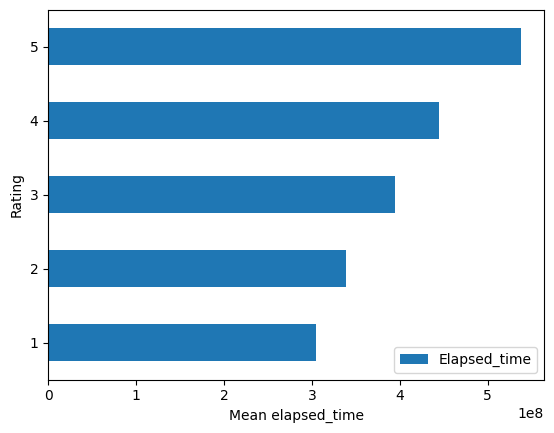

In [22]:
plt_df.groupby('Rating').mean().plot(kind='barh')
plt.xlabel('Mean elapsed_time')

In [23]:
plt_df.groupby('Rating').mean()/1e8

Elapsed_time
Rating             
1          3.049624
2           3.38405
3          3.948906
4          4.448802
5          5.373076

In [24]:
1.96*(plt_df.groupby('Rating').var()/5000)**0.5/1e8

Elapsed_time
Rating             
1          0.094967
2          0.097916
3          0.116524
4          0.126147
5          0.144664

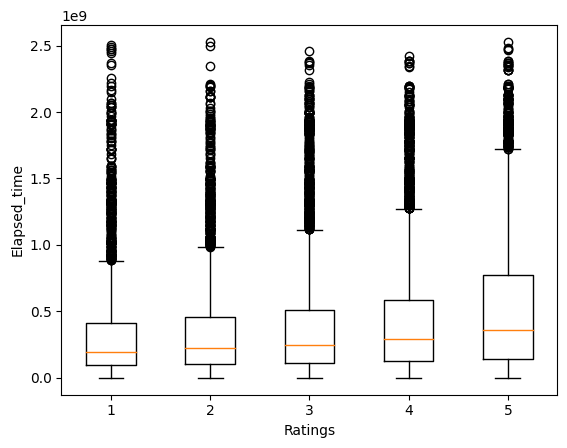

In [25]:
fig, ax = plt.subplots()
ax.boxplot([plt_df[plt_df['Rating'] == i]['Elapsed_time'] for i in range(1, 6)])
plt.xlabel('Ratings')
plt.ylabel('Elapsed_time')
plt.show()

Replace Timestamp and Movie_year with Elaped_time

In [26]:
drop_cols = ['Timestamp', 'Movie_year']
train_ratings.drop(drop_cols, axis=1, inplace=True)
test_ratings.drop(drop_cols, axis=1, inplace=True)

In [27]:
train_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Occupation',
       'Zip-code', 'Documentary', 'Drama', 'War', 'Horror', 'Thriller',
       'Romance', 'Western', 'Film-Noir', 'Children's', 'Sci-Fi', 'Crime',
       'Comedy', 'Action', 'Animation', 'Adventure', 'Fantasy', 'Musical',
       'Mystery', 'Elapsed_time'],
      dtype='object')

In [28]:
test_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Occupation',
       'Zip-code', 'Documentary', 'Musical', 'Drama', 'Western', 'Horror',
       'Thriller', 'Romance', 'Film-Noir', 'Sci-Fi', 'Children's', 'Crime',
       'Comedy', 'Action', 'Animation', 'Adventure', 'Fantasy', 'War',
       'Mystery', 'Elapsed_time'],
      dtype='object')

Preprocesss Occupation feature

In [29]:
train_ratings.groupby('Occupation')['Rating'].describe()

count      mean       std  min  25%  50%  75%  max
Occupation                                                       
0           104435.0  3.537626  1.126500  1.0  3.0  4.0  4.0  5.0
1            68321.0  3.582954  1.105104  1.0  3.0  4.0  4.0  5.0
2            40050.0  3.571885  1.140852  1.0  3.0  4.0  4.0  5.0
3            25200.0  3.656389  1.102034  1.0  3.0  4.0  5.0  5.0
4           105033.0  3.536222  1.166725  1.0  3.0  4.0  4.0  5.0
5            17444.0  3.535256  1.101804  1.0  3.0  4.0  4.0  5.0
6            29711.0  3.663727  1.109266  1.0  3.0  4.0  4.0  5.0
7            84531.0  3.601921  1.084955  1.0  3.0  4.0  4.0  5.0
8             2176.0  3.464154  1.104058  1.0  3.0  4.0  4.0  5.0
9             9015.0  3.667332  1.029374  1.0  3.0  4.0  4.0  5.0
10           18614.0  3.532395  1.223482  1.0  3.0  4.0  4.0  5.0
11           16499.0  3.622765  1.148140  1.0  3.0  4.0  4.0  5.0
12           45623.0  3.655174  1.082450  1.0  3.0  4.0  4.0  5.0
13           11039.0  3.790651  1.035132  1.0  3.0  4.0  5.0  5.0
14           39271.0  3.621655  1.090886  1.0  3.0  4.0  4.0  5.0
15           18349.0  3.692245  1.066134  1.0  3.0  4.0  4.0  5.0
16           36686.0  3.598212  1.076970  1.0  3.0  4.0  4.0  5.0
17           58253.0  3.611642  1.076992  1.0  3.0  4.0  4.0  5.0
18            9690.0  3.523942  1.070193  1.0  3.0  4.0  4.0  5.0
19           11953.0  3.412198  1.219477  1.0  3.0  4.0  4.0  5.0
20           48274.0  3.496520  1.154933  1.0  3.0  4.0  4.0  5.0

In [30]:
data = train_ratings

In [31]:
grouped_data = [group['Rating'].tolist() for name, group in data.groupby('Occupation')]

# Perform Kruskal-Wallis test
statistic, p_value = sp.stats.kruskal(*grouped_data)

# Print the results
print("Kruskal-Wallis H-test")
print("Statistic:", statistic)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: There is evidence that the means of the groups are different.")
else:
    print("Fail to reject the null hypothesis: There is no evidence that the means of the groups are different.")

Kruskal-Wallis H-test
Statistic: 1969.188929173017
p-value: 0.0
Reject the null hypothesis: There is evidence that the means of the groups are different.


In [32]:
# Perform one-hot encoding for train dataset
df_encoded = pd.get_dummies(train_ratings['Occupation'], prefix='Occupation').astype(int)

train_ratings = pd.concat([train_ratings, df_encoded], axis=1)
train_ratings.drop('Occupation', axis=1, inplace=True)

train_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Zip-code',
       'Documentary', 'Drama', 'War', 'Horror', 'Thriller', 'Romance',
       'Western', 'Film-Noir', 'Children's', 'Sci-Fi', 'Crime', 'Comedy',
       'Action', 'Animation', 'Adventure', 'Fantasy', 'Musical', 'Mystery',
       'Elapsed_time', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20'],
      dtype='object')

In [33]:
# Perform one-hot encoding for test dataset
df_encoded = pd.get_dummies(test_ratings['Occupation'], prefix='Occupation').astype(int)

test_ratings = pd.concat([test_ratings, df_encoded], axis=1)
test_ratings.drop('Occupation', axis=1, inplace=True)

test_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Zip-code',
       'Documentary', 'Musical', 'Drama', 'Western', 'Horror', 'Thriller',
       'Romance', 'Film-Noir', 'Sci-Fi', 'Children's', 'Crime', 'Comedy',
       'Action', 'Animation', 'Adventure', 'Fantasy', 'War', 'Mystery',
       'Elapsed_time', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20'],
      dtype='object')

Preprocess zip-code

In [34]:
zip_rating = train_ratings.groupby('Zip-code')['Rating'].mean()

In [35]:
zip_rating[zip_rating == min(zip_rating)]

Zip-code
98674    1.071429
Name: Rating, dtype: float64

In [36]:
zip_rating[zip_rating == max(zip_rating)]

Zip-code
46239    4.894309
Name: Rating, dtype: float64

In [37]:
zip_rating.mean()

3.691404622597087

Text(0, 0.5, 'Mean Rating')

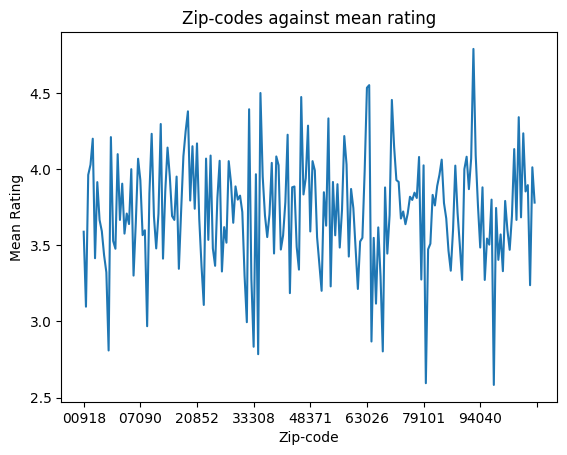

In [38]:
zip_sample = zip_rating.sample(200)
zip_sample.sort_index().plot()
plt.title("Zip-codes against mean rating")
plt.ylabel("Mean Rating")

In [39]:
zip_sample.describe()

count    200.000000
mean       3.722753
std        0.373264
min        2.583333
25%        3.488530
50%        3.720486
75%        3.963889
max        4.789474
Name: Rating, dtype: float64

In [40]:
train_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Zip-code',
       'Documentary', 'Drama', 'War', 'Horror', 'Thriller', 'Romance',
       'Western', 'Film-Noir', 'Children's', 'Sci-Fi', 'Crime', 'Comedy',
       'Action', 'Animation', 'Adventure', 'Fantasy', 'Musical', 'Mystery',
       'Elapsed_time', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20'],
      dtype='object')

In [41]:
zip_means = train_ratings.groupby('Zip-code')['Rating'].mean().reset_index()
train_ratings = pd.merge(train_ratings, zip_means, on='Zip-code', how='left')
train_ratings.rename(columns={'Rating_y': 'Zip-mean', 'Rating_x': 'Rating'}, inplace=True)

overall_mean = train_ratings['Rating'].mean()

In [42]:
test_ratings = pd.merge(test_ratings, zip_means, on='Zip-code', how='left')
test_ratings.rename(columns={'Rating_y': 'Zip-mean', 'Rating_x': 'Rating'}, inplace=True)

In [43]:
test_ratings['Zip-mean'] = test_ratings['Zip-mean'].fillna(overall_mean)

test_ratings.columns

Index(['UserID', 'MovieID', 'Rating', 'Title', 'Gender', 'Age', 'Zip-code',
       'Documentary', 'Musical', 'Drama', 'Western', 'Horror', 'Thriller',
       'Romance', 'Film-Noir', 'Sci-Fi', 'Children's', 'Crime', 'Comedy',
       'Action', 'Animation', 'Adventure', 'Fantasy', 'War', 'Mystery',
       'Elapsed_time', 'Occupation_0', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20', 'Zip-mean'],
      dtype='object')

In [44]:
drop_cols = ['UserID', 'MovieID', 'Zip-code', 'Title']

train_ratings.drop(drop_cols, axis=1, inplace=True)
test_ratings.drop(drop_cols, axis=1, inplace=True)

In [45]:
train_ratings.columns

Index(['Rating', 'Gender', 'Age', 'Documentary', 'Drama', 'War', 'Horror',
       'Thriller', 'Romance', 'Western', 'Film-Noir', 'Children's', 'Sci-Fi',
       'Crime', 'Comedy', 'Action', 'Animation', 'Adventure', 'Fantasy',
       'Musical', 'Mystery', 'Elapsed_time', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20', 'Zip-mean'],
      dtype='object')

In [46]:
train_ratings.head(3)

Rating  Gender  Age  Documentary  Drama  War  Horror  Thriller  Romance  \
0       3       0   25            0      1    0       0         0        0   
1       3       0   25            0      1    0       0         0        0   
2       3       0   25            0      0    0       0         0        1   

   Western  ...  Occupation_12  Occupation_13  Occupation_14  Occupation_15  \
0        0  ...              0              0              0              0   
1        0  ...              0              0              0              0   
2        0  ...              0              0              0              0   

   Occupation_16  Occupation_17  Occupation_18  Occupation_19  Occupation_20  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   Zip-mean  
0     4.144  
1     4.144  
2     4.144  

[3 rows x 44 columns]

In [47]:
X = train_ratings.loc[:, 'Gender':]
Y = train_ratings.loc[:, 'Rating']

test_X = test_ratings.loc[:, 'Gender':]
test_Y = test_ratings.loc[:, 'Rating']

In [48]:
print(f"X.shape {X.shape}")
print(f"Y.shape {Y.shape}")
print(f"test_X.shape {test_X.shape}")
print(f"test_Y.shape {test_Y.shape}")

X.shape (800167, 43)
Y.shape (800167,)
test_X.shape (200042, 43)
test_Y.shape (200042,)


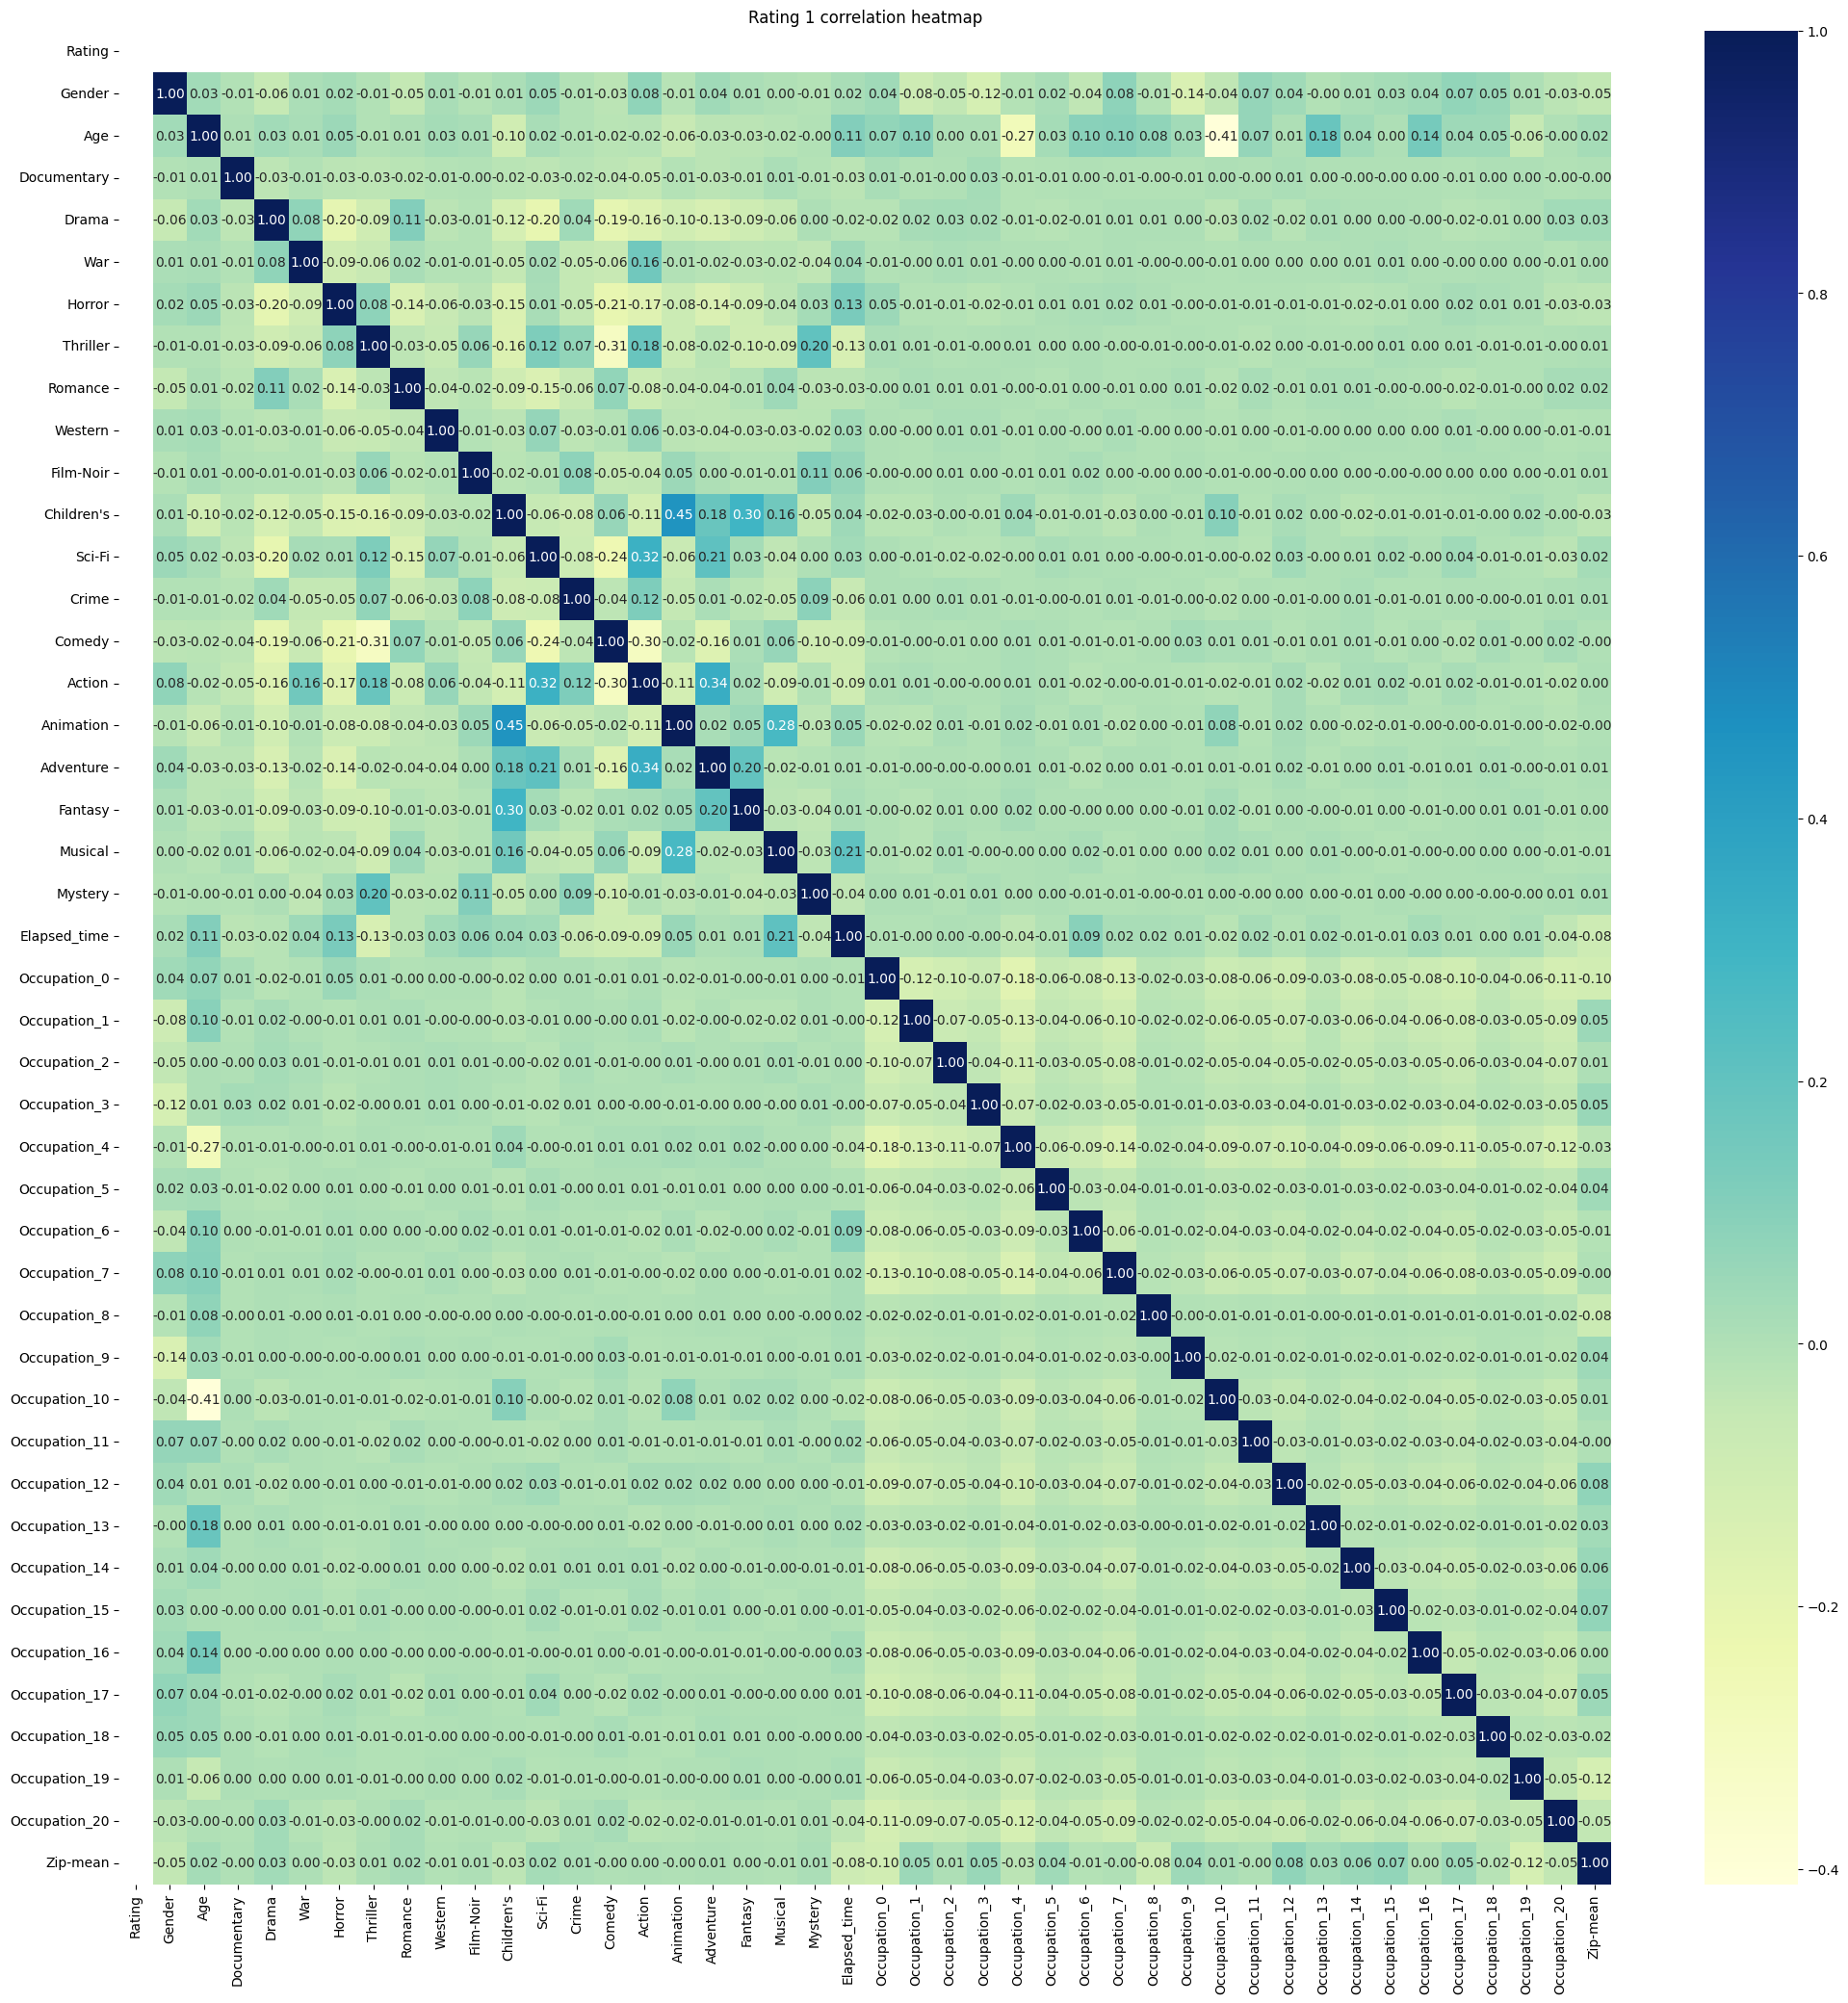

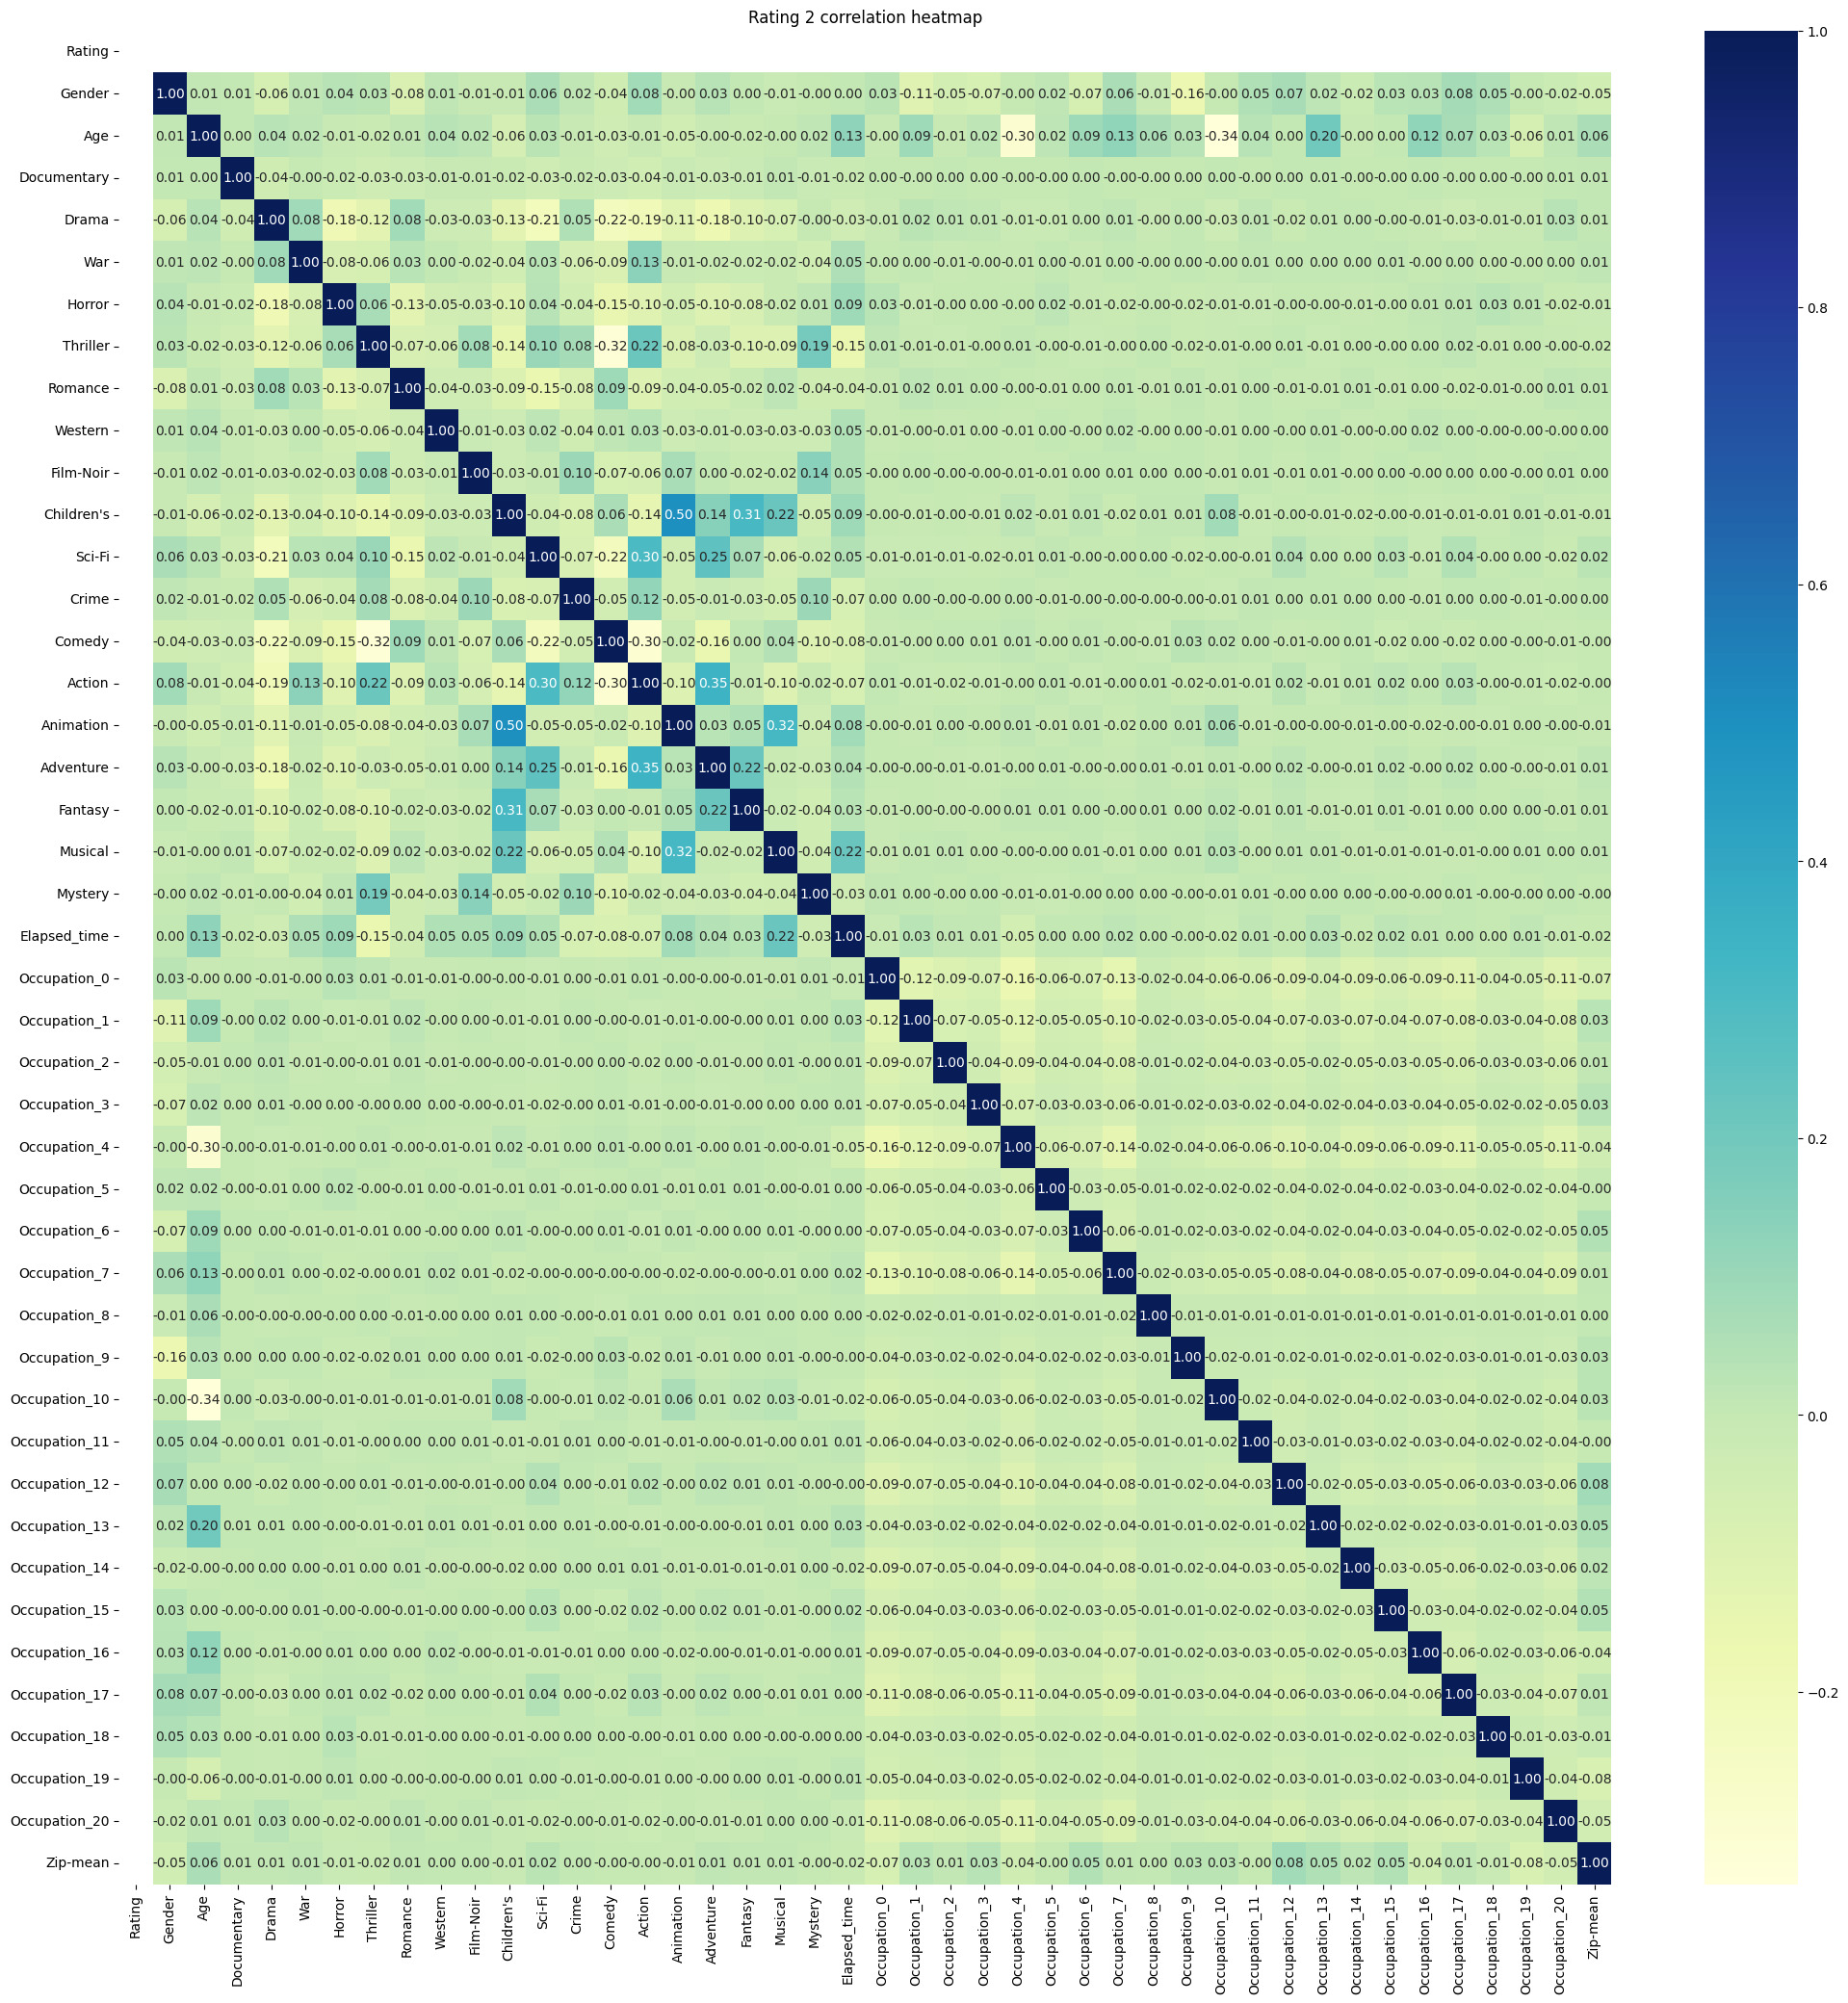

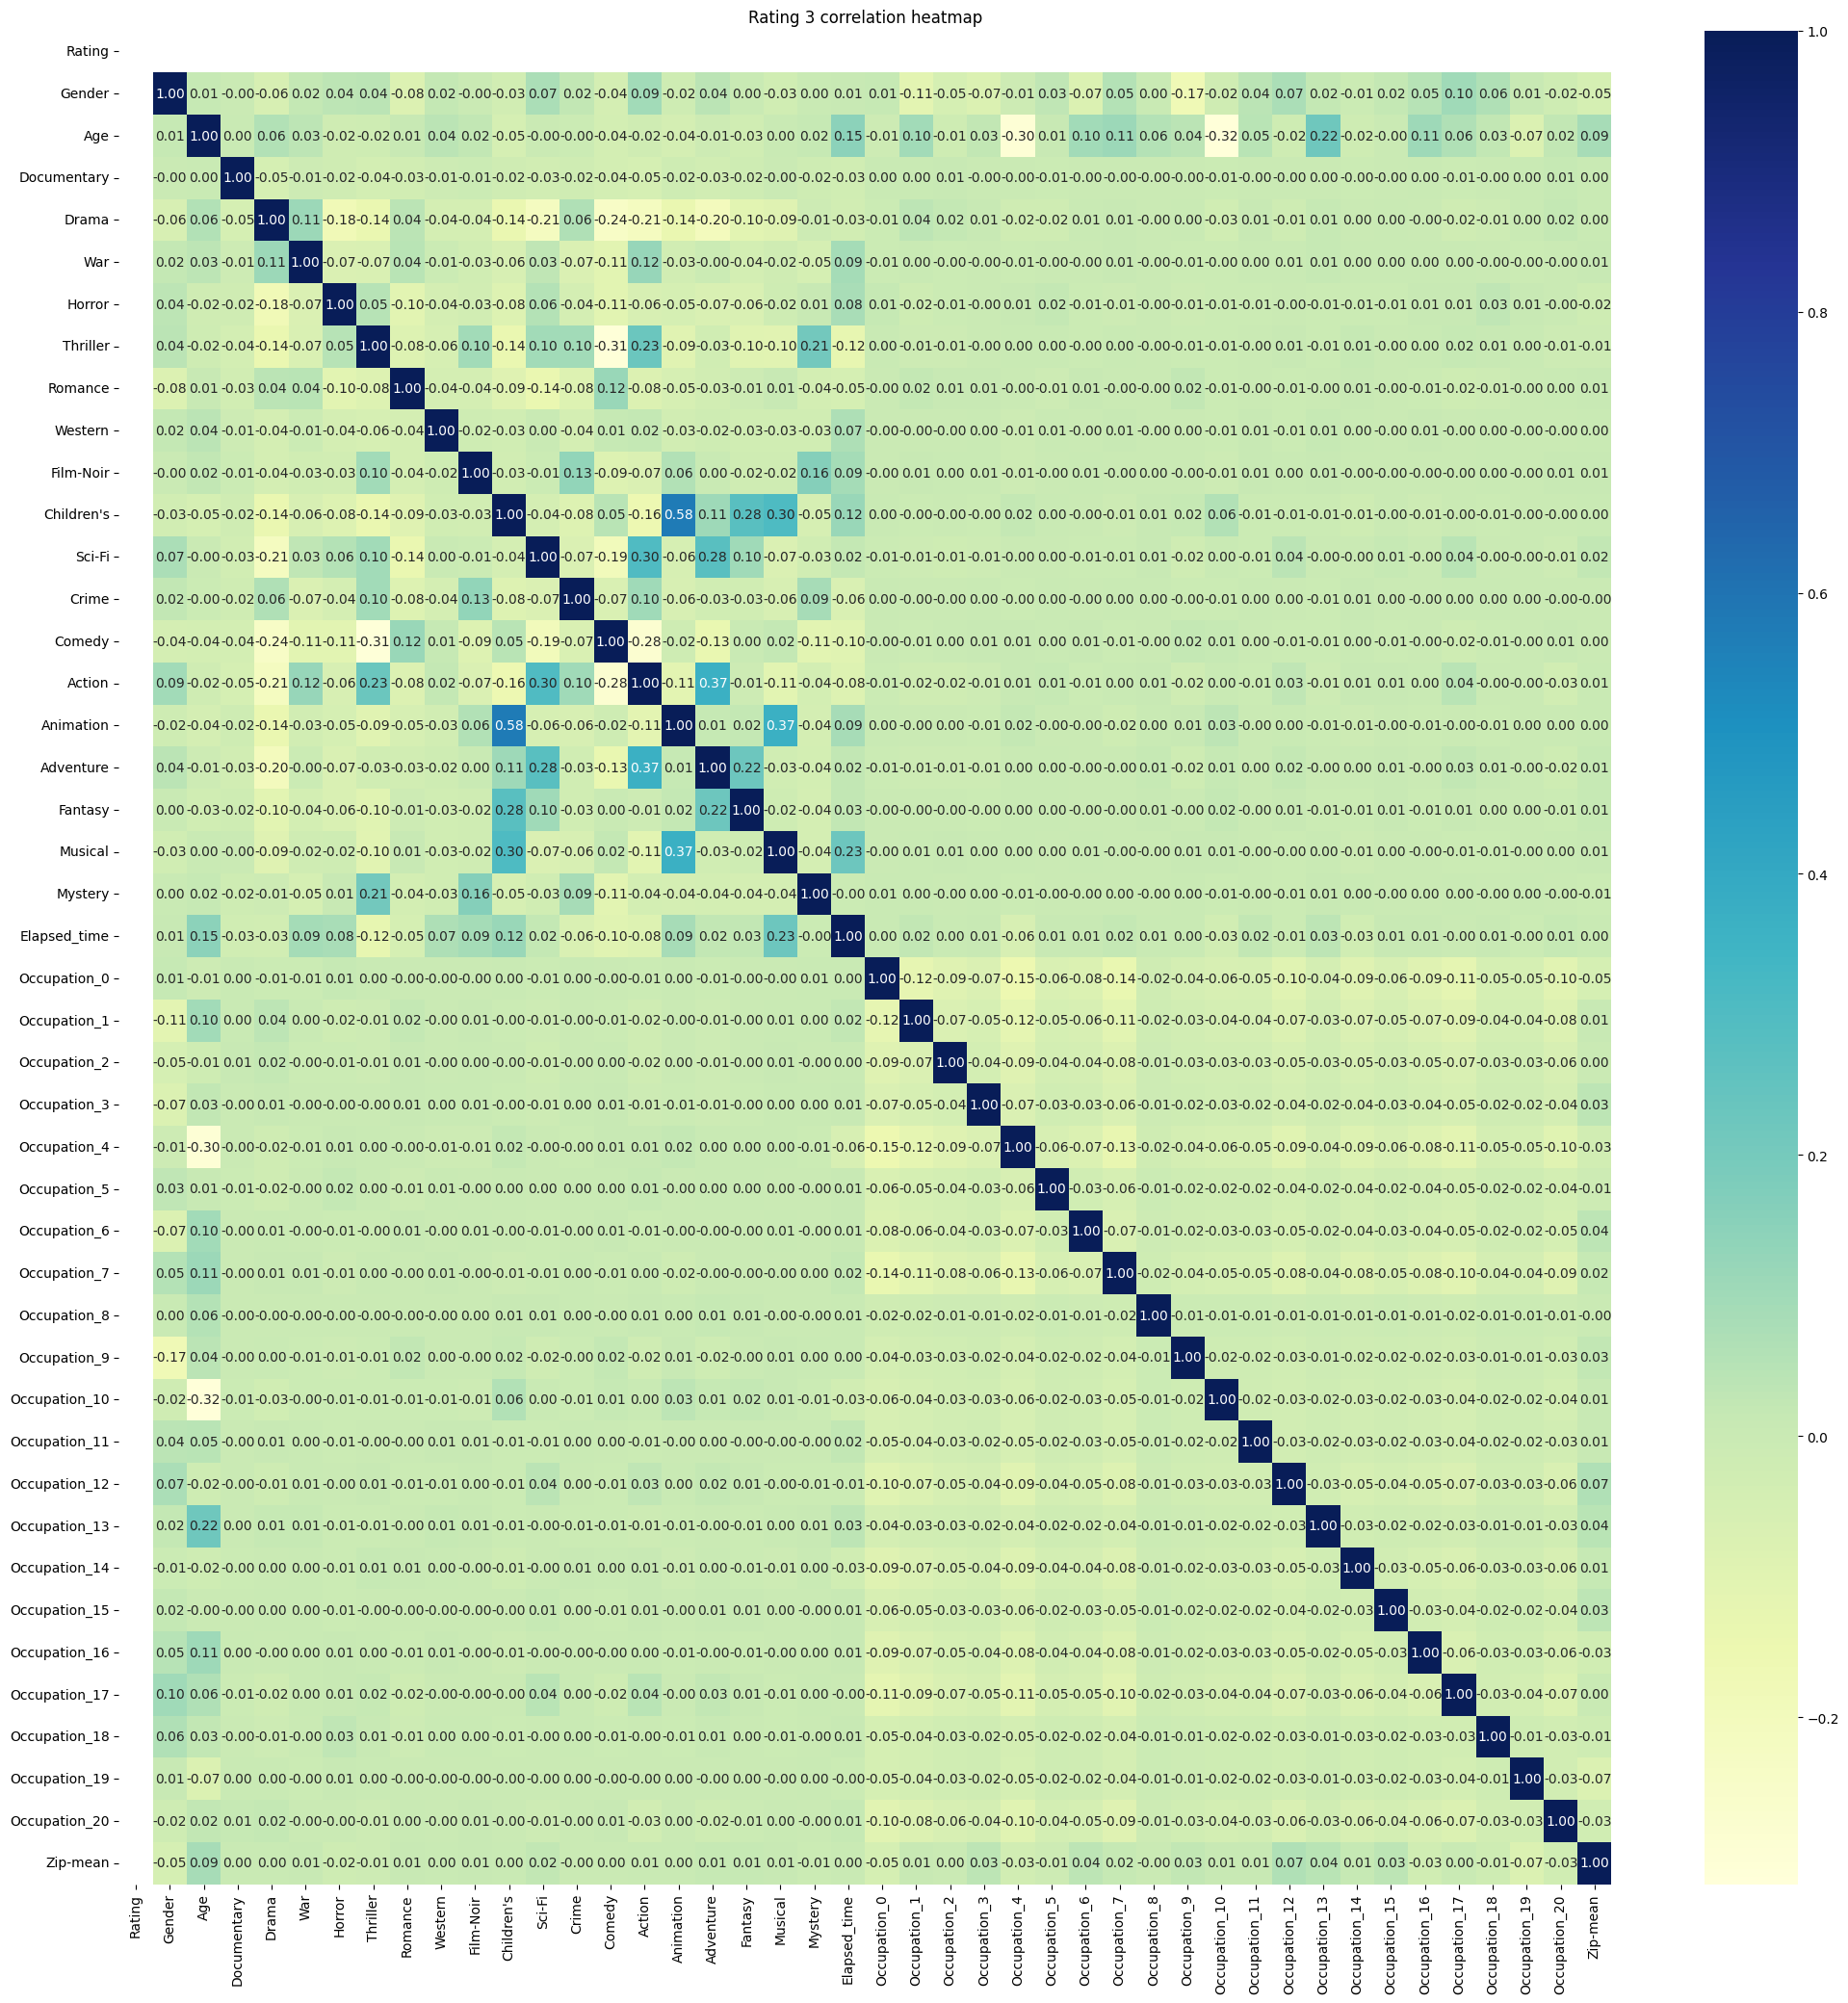

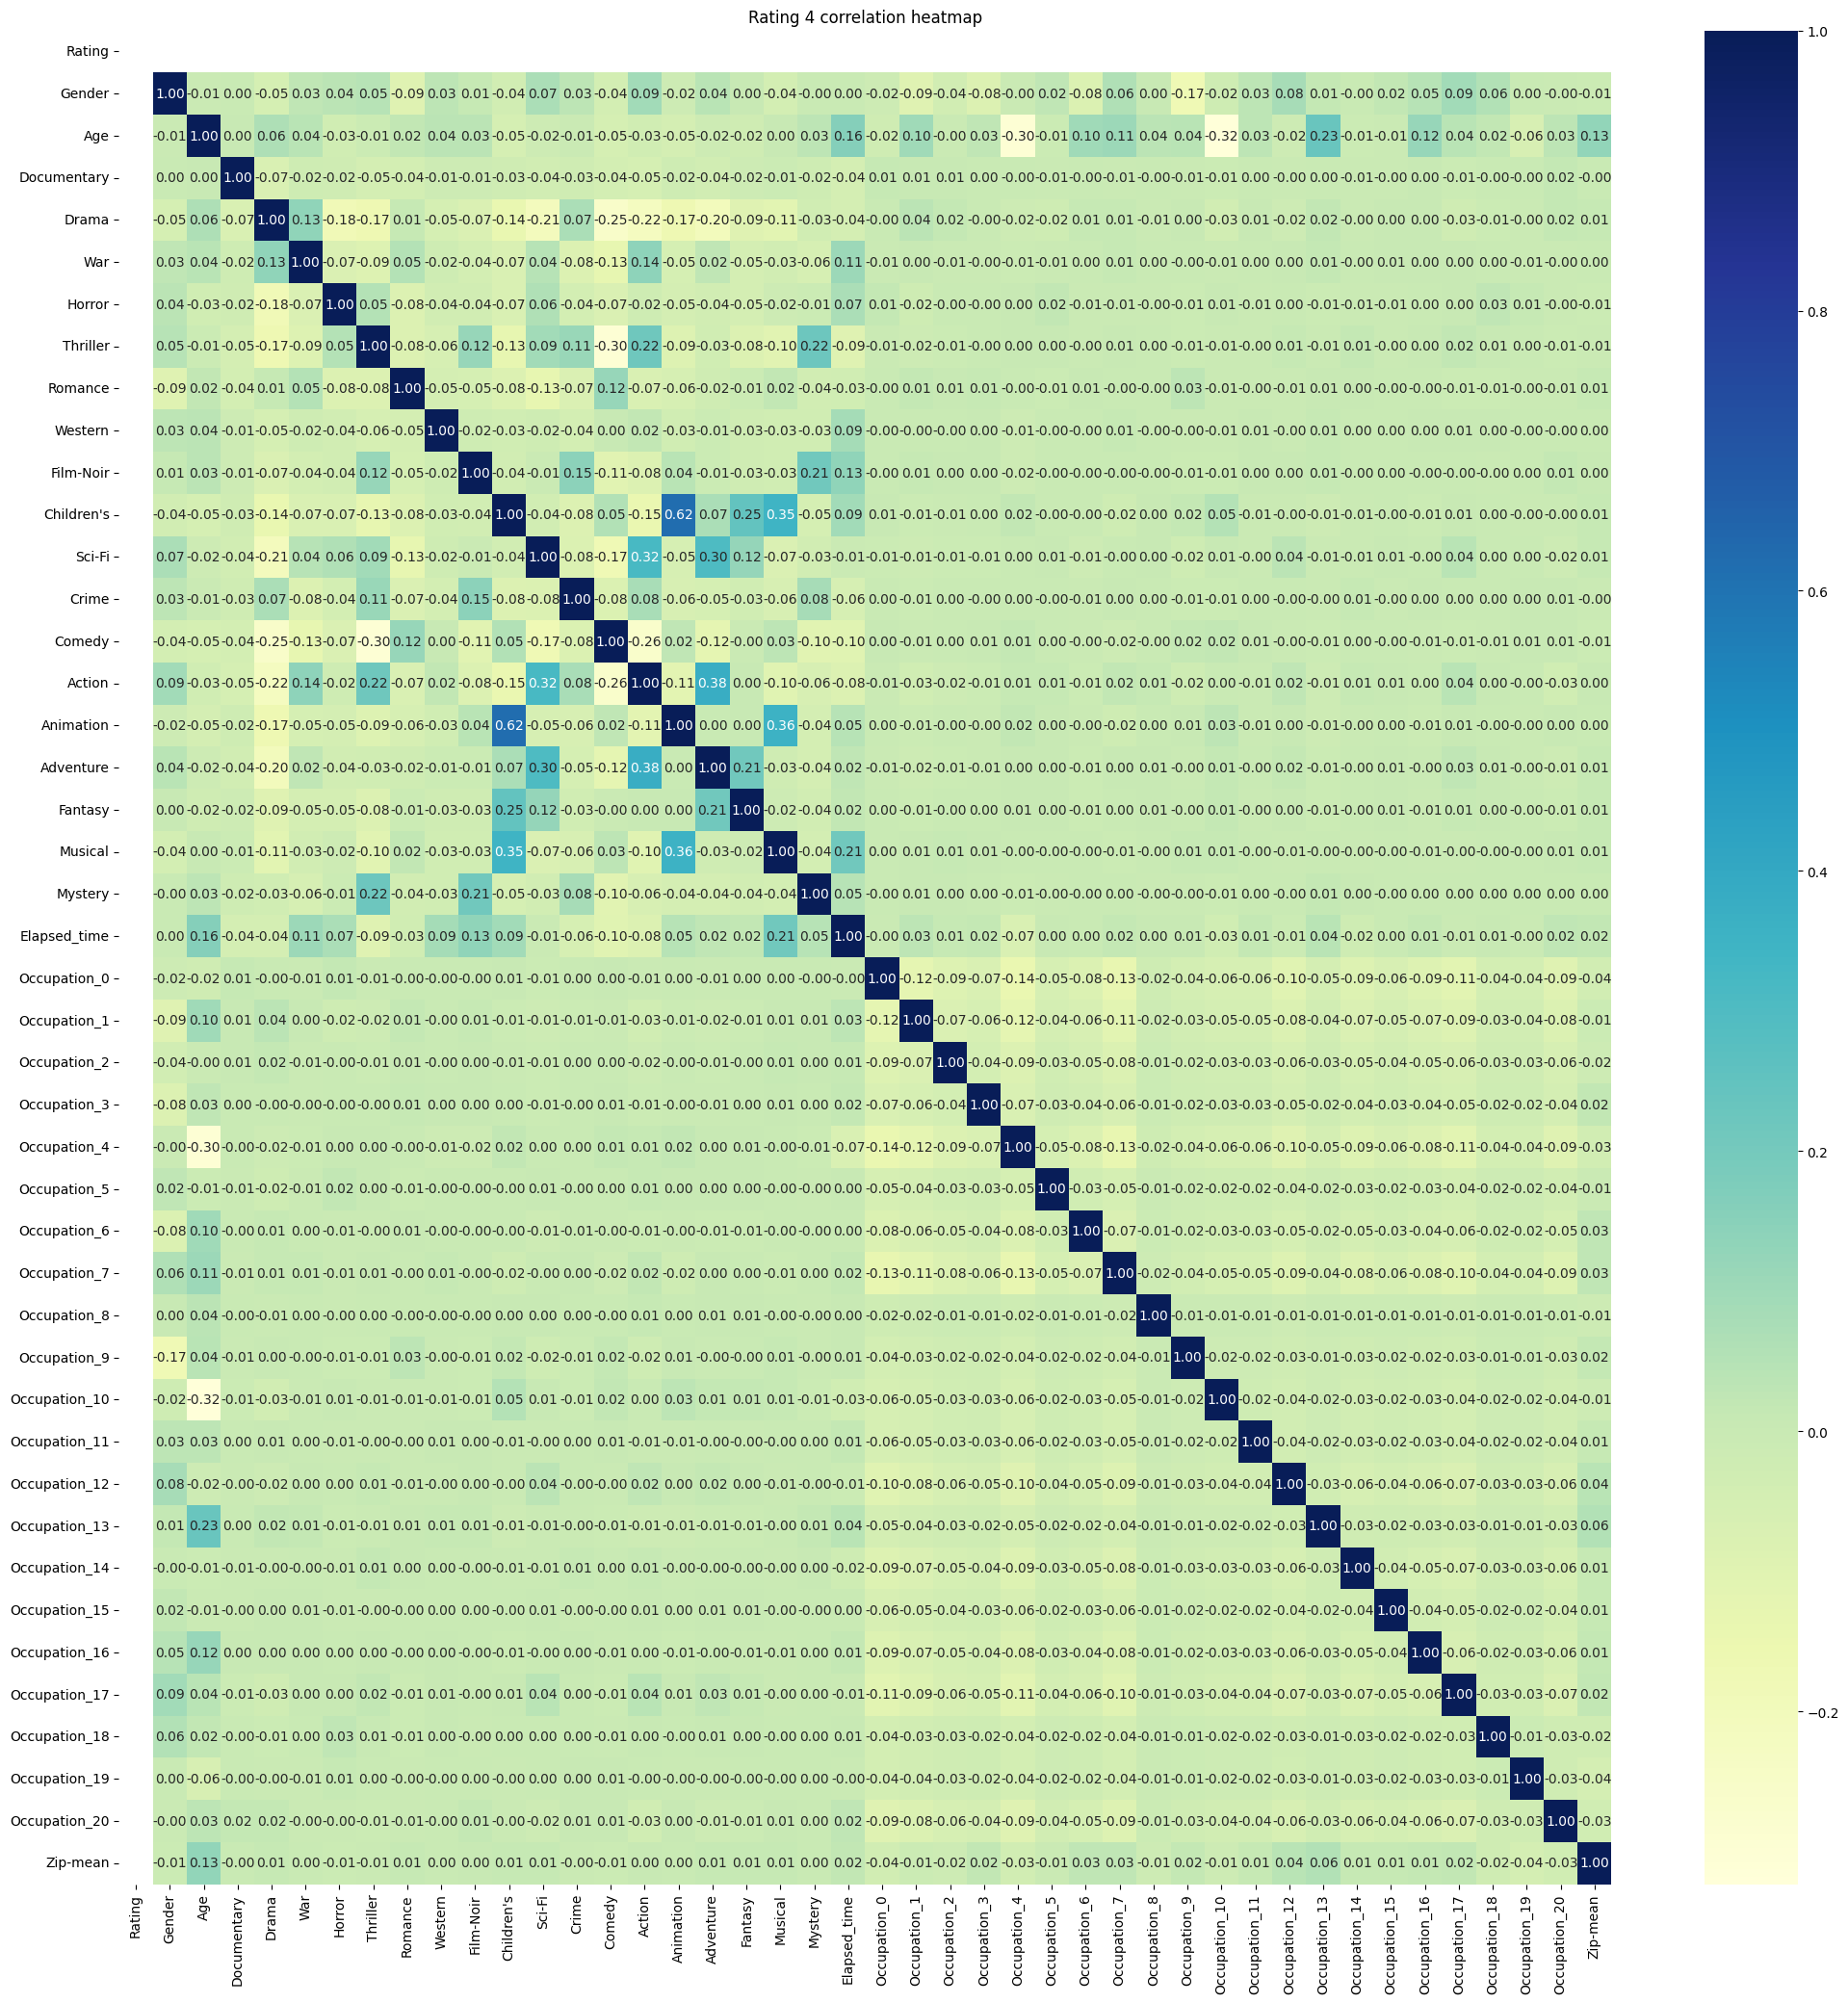

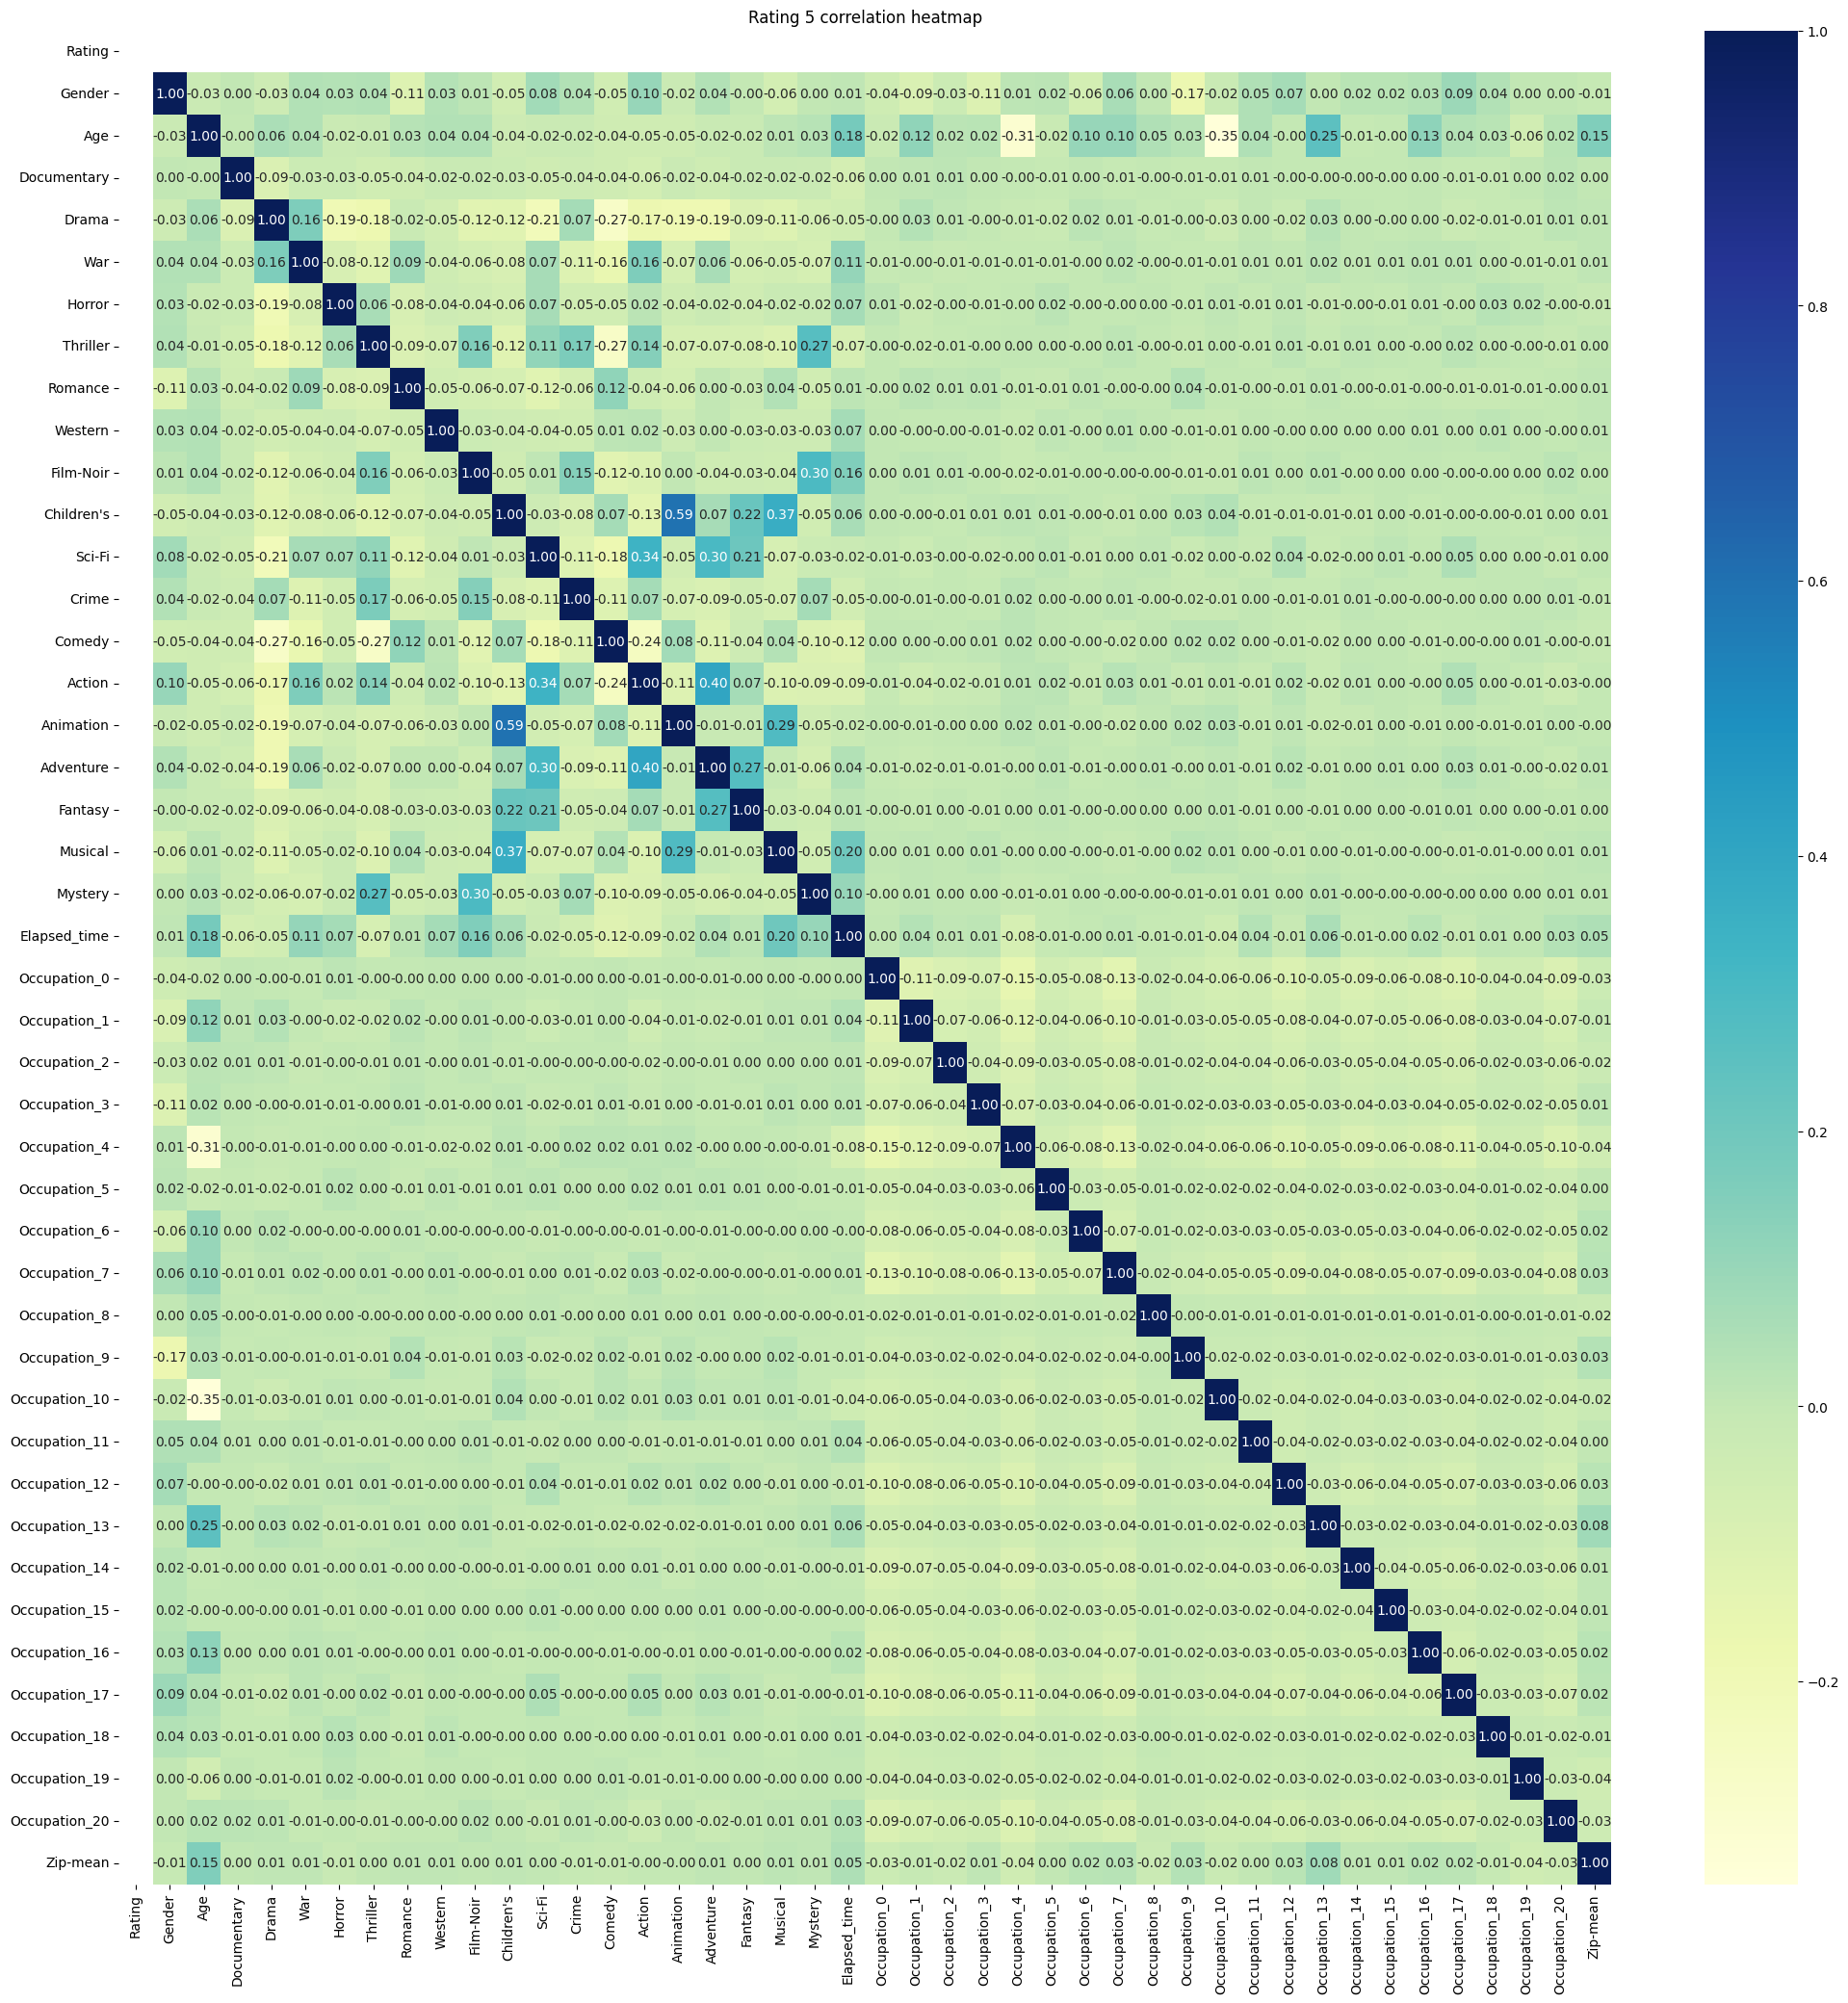

In [49]:
import seaborn as sb

for i in range(1, 6):
  plt.figure(figsize=(25, 25))
  dataplot = sb.heatmap(train_ratings[train_ratings['Rating'] == i].corr(), cmap="YlGnBu", fmt='.2f', annot=True)
  plt.title(f"Rating {i} correlation heatmap")
  plt.show()

Model implementation

In [ ]:
class k_prototype:
    def __init(self, k=None):
        self.k = k
        pass
    
    def fit(self, X, y):
        if self.k == None:
            self.k = len(y.value_counts())
        

    def loss(self, x1, x2):
        
                

In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probabilities = {}  # Dictionary to store class probabilities
        self.feature_probabilities = {}  # Nested dictionary to store feature probabilities

    def train(self, X, y):
        # X is a list of feature vectors
        # y is a list of corresponding class labels
        num_samples = len(X)
        num_features = len(X[0])

        # Calculate class probabilities
        for label in y:
            if label in self.class_probabilities:
                self.class_probabilities[label] += 1
            else:
                self.class_probabilities[label] = 1

        for label in self.class_probabilities:
            self.class_probabilities[label] /= num_samples

        # Calculate feature probabilities
        for i in range(num_samples):
            for j in range(num_features):
                feature = X[i][j]
                label = y[i]
                if label not in self.feature_probabilities:
                    self.feature_probabilities[label] = {}
                if j not in self.feature_probabilities[label]:
                    self.feature_probabilities[label][j] = {}

                if feature in self.feature_probabilities[label][j]:
                    self.feature_probabilities[label][j][feature] += 1
                else:
                    self.feature_probabilities[label][j][feature] = 1

        # Normalize feature probabilities
        for label in self.feature_probabilities:
            for j in self.feature_probabilities[label]:
                total_count = sum(self.feature_probabilities[label][j].values())
                for feature in self.feature_probabilities[label][j]:
                    self.feature_probabilities[label][j][feature] /= total_count

    def predict(self, X):
        predictions = []
        for sample in X:
            max_probability = -1
            predicted_class = None
            for label in self.class_probabilities:
                class_probability = self.class_probabilities[label]
                for j in range(len(sample)):
                    feature = sample[j]
                    if label in self.feature_probabilities and j in self.feature_probabilities[label]:
                        if feature in self.feature_probabilities[label][j]:
                            class_probability *= self.feature_probabilities[label][j][feature]
                        else:
                            class_probability *= 0  # Laplace smoothing: feature not seen in training
                    else:
                        class_probability *= 0  # Laplace smoothing: class not seen in training
                if class_probability > max_probability:
                    max_probability = class_probability
                    predicted_class = label
            predictions.append(predicted_class)
        return predictions

In [ ]:
model = NaiveBayesClassifier()


model.train(train_ratings[['Gender', 'Age', 'Romance', 'Crime', 'Thriller', 'Adventure',
       'Film-Noir', "Children's", 'Documentary', 'Horror', 'Western', 'Sci-Fi',
       'Comedy', 'Animation', 'Fantasy', 'Action', 'Mystery', 'War', 'Drama',
       'Musical', 'Elapsed_time', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20', 'Zip-mean']].values, 
       train_ratings['Rating'].values)

In [ ]:
train_ratings.columns

Index(['Rating', 'Gender', 'Age', 'Romance', 'Crime', 'Thriller', 'Adventure',
       'Film-Noir', 'Children's', 'Documentary', 'Horror', 'Western', 'Sci-Fi',
       'Comedy', 'Animation', 'Fantasy', 'Action', 'Mystery', 'War', 'Drama',
       'Musical', 'Elapsed_time', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20', 'Zip-mean'],
      dtype='object')

In [ ]:
y_pred = model.predict(test_ratings[['Gender', 'Age', 'Romance', 'Crime', 'Thriller', 'Adventure',
       'Film-Noir', "Children's", 'Documentary', 'Horror', 'Western', 'Sci-Fi',
       'Comedy', 'Animation', 'Fantasy', 'Action', 'Mystery', 'War', 'Drama',
       'Musical', 'Elapsed_time', 'Occupation_0', 'Occupation_1',
       'Occupation_2', 'Occupation_3', 'Occupation_4', 'Occupation_5',
       'Occupation_6', 'Occupation_7', 'Occupation_8', 'Occupation_9',
       'Occupation_10', 'Occupation_11', 'Occupation_12', 'Occupation_13',
       'Occupation_14', 'Occupation_15', 'Occupation_16', 'Occupation_17',
       'Occupation_18', 'Occupation_19', 'Occupation_20', 'Zip-mean']].values)

np.mean((y_pred-test_ratings['Rating'].values)**2)

1.5982443686825767